In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
import time


c:\Users\Michael Stewart\.conda\envs\machine-learning\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Define your path
IMG_DIR = "../../img_align_celeba_small"
BATCH_SIZE = 64
IMG_SIZE = 64  
LATENT_DIM = 100

In [3]:
# -----------------------------------------------------------------------------
# 1) DATA PRE-PROCESSING
# -----------------------------------------------------------------------------

# Preprocessing function
def preprocess_image(file_path):
    # Read image from disk
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    
    # Normalize to [-1, 1]
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    
    return img

# Create dataset
dataset = (
    tf.data.Dataset.list_files(os.path.join(IMG_DIR, "*.jpg"), shuffle=True)
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(buffer_size=10000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [4]:
# -------------------------------------------------------------------------
# 2) GENERATOR for 64×64
# -------------------------------------------------------------------------
def build_generator():
    model = tf.keras.Sequential(name="Generator")
    # Dense → 8×8×256
    model.add(layers.Input(shape=(LATENT_DIM,)))
    model.add(layers.Dense(8*8*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 256)))  # → (8,8,256)

    # 8→16
    model.add(layers.Conv2DTranspose(128, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 16→32
    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 32→64  ← final upsample to your target size
    model.add(layers.Conv2DTranspose(3,   # RGB output
                                     5,
                                     strides=2,
                                     padding="same",
                                     use_bias=False,
                                     activation="tanh"))
    return model

# -------------------------------------------------------------------------
# 3) DISCRIMINATOR for 64×64
# -------------------------------------------------------------------------
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    # 64→32
    model.add(layers.Conv2D(64, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 32→16
    model.add(layers.Conv2D(128, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 16→8
    model.add(layers.Conv2D(256, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 8→4  (optional; you can stop here)
    model.add(layers.Conv2D(512, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))   # output logits
    return model

generator     = build_generator()
discriminator = build_discriminator()

In [5]:
# -------------------------------------------------------------------------
# 2) GENERATOR for 64×64
# -------------------------------------------------------------------------
def build_generator():
    model = tf.keras.Sequential(name="Generator")
    # Dense → 8×8×256
    model.add(layers.Input(shape=(LATENT_DIM,)))
    model.add(layers.Dense(8*8*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 256)))  # → (8,8,256)

    # 8→16
    model.add(layers.Conv2DTranspose(128, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 16→32
    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 32→64  ← final upsample to your target size
    model.add(layers.Conv2DTranspose(3,   # RGB output
                                     5,
                                     strides=2,
                                     padding="same",
                                     use_bias=False,
                                     activation="tanh"))
    return model

# -------------------------------------------------------------------------
# 3) DISCRIMINATOR for 64×64
# -------------------------------------------------------------------------
def build_discriminator():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    # 64→32
    model.add(layers.Conv2D(64, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 32→16
    model.add(layers.Conv2D(128, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 16→8
    model.add(layers.Conv2D(256, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 8→4  (optional; you can stop here)
    model.add(layers.Conv2D(512, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))   # output logits
    return model

generator     = build_generator()
discriminator = build_discriminator()

In [6]:
# -----------------------------------------------------------------------------
# 4) LOSS, OPTIMIZERS & METRICS
# -----------------------------------------------------------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

#CHANGE: increase D learning rate to be 4 times the G learning rate
generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)

# track metrics
d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
d_accuracy   = tf.keras.metrics.BinaryAccuracy(name="d_accuracy")

In [7]:
# -----------------------------------------------------------------------------
# 5) DEFINE TRAIN STEP
# -----------------------------------------------------------------------------
@tf.function
def train_generator_step():
    # sample noise
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        # note: we only need D to evaluate G here, no D gradient on real
        g_loss = generator_loss(discriminator(fake, training=False))
    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    g_loss_metric.update_state(g_loss)

@tf.function
def train_discriminator_step(real_images):
    # generate a fresh batch of fakes
    noise = tf.random.normal([tf.shape(real_images)[0], LATENT_DIM])
    fake = generator(noise, training=True)
    with tf.GradientTape() as tape:
        real_out = discriminator(real_images, training=True)
        fake_out = discriminator(fake, training=True)
        d_loss = discriminator_loss(real_out, fake_out)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    d_loss_metric.update_state(d_loss)
    real_labels = tf.ones_like(real_out)
    d_accuracy.update_state(real_labels, real_out)

In [ ]:
# -----------------------------------------------------------------------------
# 6) TRAINING
# -----------------------------------------------------------------------------

# where to dump samples & weights
CHECKPOINT_DIR = "./v1.3_training_checkpoints"
GENERATED_IMAGE_DIR = "./v1.3_generated_samples"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(GENERATED_IMAGE_DIR, exist_ok=True)

def generate_and_save_images(model, epoch, test_input):
    # model outputs in [-1,1], scale to [0,1]
    preds = (model(test_input, training=False) + 1.0) * 0.5
    fig = plt.figure(figsize=(4,4))
    for i in range(preds.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i].numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{GENERATED_IMAGE_DIR}/image_epoch_{epoch:03d}.png")
    plt.close(fig)

# a fixed seed so you can watch interpolation over epochs
NUM_EXAMPLES_TO_GENERATE = 16
fixed_seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

# Training
g_losses = []
d_losses = []
d_accs = []
EPOCHS = 50
WEIGHT_SAVE_FREQ = 1
PICTURE_GENERATION_FREQ = 1

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    print(f"\nEpoch {epoch}/{EPOCHS}")
    num_batches = tf.data.experimental.cardinality(dataset).numpy()
    progbar = Progbar(num_batches,
                      stateful_metrics=["g_loss","d_loss","d_acc"],
                      verbose=1)

    # reset metrics
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    d_accuracy.reset_states()

    # iterate batches
    for i, batch in enumerate(dataset, start=1):
        # **one** D-step
        train_discriminator_step(batch)
        # **CHANGE: **one** G-step, and train G after D
        train_generator_step()

        progbar.update(i, [
            ("g_loss", g_loss_metric.result()),
            ("d_loss", d_loss_metric.result()),
            ("d_acc",  d_accuracy.result())
        ])

    # record history
    g_losses.append(float(g_loss_metric.result().numpy()))
    d_losses.append(float(d_loss_metric.result().numpy()))
    d_accs.append(float(d_accuracy.result().numpy()))

    # generate & save samples
    if epoch % PICTURE_GENERATION_FREQ == 0:
        generate_and_save_images(generator, epoch, fixed_seed)

    # save weights
    if epoch % WEIGHT_SAVE_FREQ == 0:
        gen_path  = os.path.join(CHECKPOINT_DIR, f"generator_epoch_{epoch:03d}.h5")
        disc_path = os.path.join(CHECKPOINT_DIR, f"discriminator_epoch_{epoch:03d}.h5")
        generator.save_weights(gen_path)
        discriminator.save_weights(disc_path)

    # measure and print epoch duration
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")



Epoch 1/50
780/780 [==============================] - 4401s 6s/step - g_loss: 2.4817 - d_loss: 0.7571 - d_acc: 0.7512
Epoch 1 completed in 4401.31 seconds

Epoch 2/50
780/780 [==============================] - 5904s 8s/step - g_loss: 2.1881 - d_loss: 0.7786 - d_acc: 0.7207
Epoch 2 completed in 5904.37 seconds

Epoch 3/50
780/780 [==============================] - 5882s 8s/step - g_loss: 1.1430 - d_loss: 1.4069 - d_acc: 0.3993
Epoch 3 completed in 5882.76 seconds

Epoch 4/50
780/780 [==============================] - 5880s 8s/step - g_loss: 1.5947 - d_loss: 1.0588 - d_acc: 0.5570
Epoch 4 completed in 5880.33 seconds

Epoch 5/50
780/780 [==============================] - 5880s 8s/step - g_loss: 1.5106 - d_loss: 1.0778 - d_acc: 0.5433
Epoch 5 completed in 5880.83 seconds

Epoch 6/50
780/780 [==============================] - 5890s 8s/step - g_loss: 1.7444 - d_loss: 0.9831 - d_acc: 0.6003
Epoch 6 completed in 5890.95 seconds

Epoch 7/50
780/780 [==============================] - 5895s 8s/

KeyboardInterrupt: 

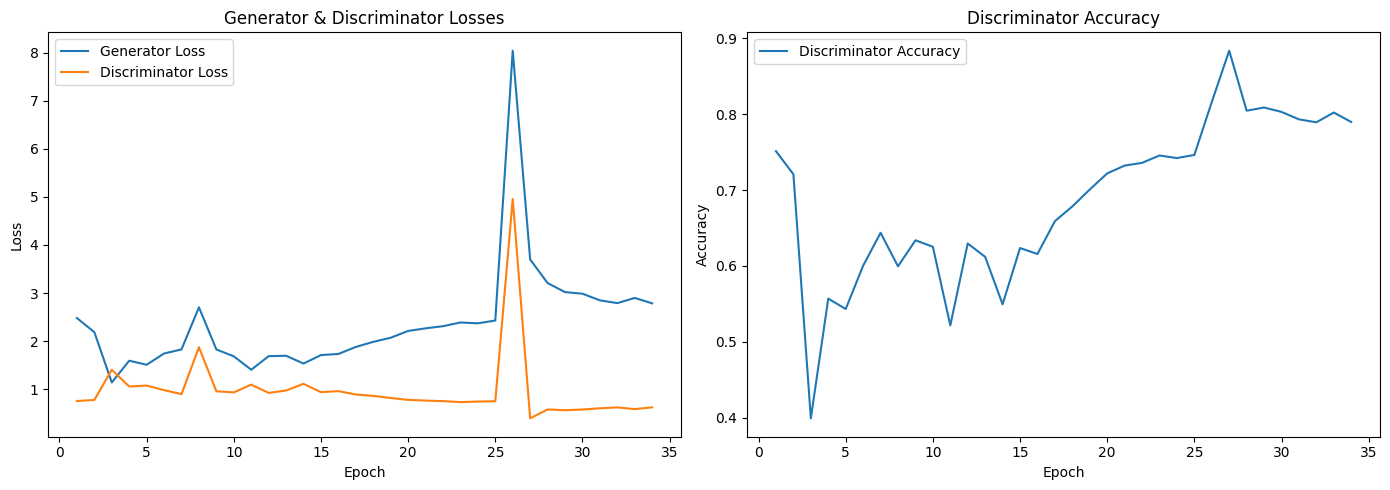

In [10]:
import matplotlib.pyplot as plt

# Define lists of metrics extracted from your training history
g_losses = [
    2.4817, 2.1881, 1.1430, 1.5947, 1.5106, 1.7444, 1.8297, 2.7040,
    1.8285, 1.6856, 1.4068, 1.6895, 1.6977, 1.5353, 1.7122, 1.7352,
    1.8810, 1.9871, 2.0721, 2.2136, 2.2676, 2.3121, 2.3895, 2.3720,
    2.4302, 8.0380, 3.7001, 3.2091, 3.0207, 2.9874, 2.8497, 2.7917,
    2.8996, 2.7869
]
d_losses = [
    0.7571, 0.7786, 1.4069, 1.0588, 1.0778, 0.9831, 0.9000, 1.8756,
    0.9593, 0.9364, 1.0978, 0.9255, 0.9758, 1.1139, 0.9406, 0.9630,
    0.8926, 0.8639, 0.8203, 0.7809, 0.7661, 0.7547, 0.7342, 0.7459,
    0.7528, 4.9553, 0.3969, 0.5812, 0.5657, 0.5808, 0.6054, 0.6241,
    0.5887, 0.6256
]
d_accs = [
    0.7512, 0.7207, 0.3993, 0.5570, 0.5433, 0.6003, 0.6437, 0.5995,
    0.6338, 0.6253, 0.5217, 0.6296, 0.6120, 0.5495, 0.6236, 0.6158,
    0.6590, 0.6784, 0.7007, 0.7219, 0.7322, 0.7358, 0.7455, 0.7421,
    0.7462, 0.8159, 0.8835, 0.8045, 0.8087, 0.8029, 0.7931, 0.7892,
    0.8021, 0.7896
]

epochs = range(1, len(g_losses) + 1)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
ax1.plot(epochs, g_losses, label='Generator Loss')
ax1.plot(epochs, d_losses, label='Discriminator Loss')
ax1.set_title('Generator & Discriminator Losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.plot(epochs, d_accs, label='Discriminator Accuracy')
ax2.set_title('Discriminator Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()
